In [1]:
from pandas import read_excel, DataFrame 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

import numpy as np
import eli5



In [2]:
gpu = False

from psutil import virtual_memory
print(virtual_memory().total / 1e9)

if gpu:
    !nvidia-smi


34.273439744


In [3]:
dataset = read_excel('data.xlsx', "sales")
dataset.head()

,Итого,Требуемый товар,Код товара,Подразделение,Дата,sales_last_7_loads
0,-2,Кефир 1% Маричка Плёнка 450г 20 шт,9254,VIP,2019-01-03,0
1,7,Кефир 1% Маричка Плёнка 450г 20 шт,9254,VIP,2019-01-04,0
2,-1,Кефир 1% Маричка Плёнка 450г 20 шт,9254,VIP,2019-01-05,0
3,-3,Кефир 1% Маричка Плёнка 450г 20 шт,9254,VIP,2019-01-07,0
4,-1,Кефир 1% Маричка Плёнка 450г 20 шт,9254,VIP,2019-01-08,0


In [4]:
departments = { "VIP":1, "Розница":2 }

dataset["Подразделение"] = dataset["Подразделение"].replace(departments)
dataset

,Итого,Требуемый товар,Код товара,Подразделение,Дата,sales_last_7_loads
0,-2,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-03,0
1,7,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-04,0
2,-1,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-05,0
3,-3,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-07,0
4,-1,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-08,0
...,...,...,...,...,...,...
420009,30,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-19,0
420010,22,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-20,134
420011,23,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-21,156
420012,15,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-22,166


In [11]:
ds = dataset
ds["Дата"] = pd.to_datetime(ds["Дата"])
ds = ds.sort_values(by=["Код товара", "Подразделение", "Дата"], ascending=True)

ds = ds[ds["Итого"] > 0]
ds = ds[ds["sales_last_7_loads"] > 0]


In [12]:
def feature_engineering(df):
    ds["dayofweek"] = ds["Дата"].dt.dayofweek
    ds["dayofyear"] = ds["Дата"].dt.dayofyear
    ds["week"] = ds["Дата"].dt.isocalendar().week
    ds["month"] = ds["Дата"].dt.month

    return df

feature_engineering(ds)

,Итого,Требуемый товар,Код товара,Подразделение,Дата,sales_last_7_loads,dayofweek,dayofyear,week,month
10,8,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-15,5,1,15,3,1
11,4,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-16,10,2,16,3,1
12,2,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-17,27,3,17,3,1
13,8,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-18,33,4,18,3,1
15,2,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-21,32,0,21,4,1
...,...,...,...,...,...,...,...,...,...,...
185114,11,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,1,2023-04-24,23,0,114,17,4
420010,22,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-20,134,3,110,16,4
420011,23,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-21,156,4,111,16,4
420012,15,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-22,166,5,112,16,4


In [182]:
ds_squ = ds[["Код товара", "Подразделение", "Итого"]].groupby(["Код товара", "Подразделение"]).agg(["mean", "std", "median", "size"])

ds_ext = pd.merge(ds, ds_squ, on=["Код товара", "Подразделение"], how="left").fillna(-1)
ds_ext

c:\Users\derachic_ai\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


,Итого,Требуемый товар,Код товара,Подразделение,Дата,sales_last_7_loads,dayofweek,dayofyear,week,month,"(Итого, mean)","(Итого, std)","(Итого, median)","(Итого, size)"
0,8,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-15,5,1,15,3,1,5.333333,4.327502,5.0,45
1,4,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-16,10,2,16,3,1,5.333333,4.327502,5.0,45
2,2,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-17,27,3,17,3,1,5.333333,4.327502,5.0,45
3,8,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-18,33,4,18,3,1,5.333333,4.327502,5.0,45
4,2,Кефир 1% Маричка Плёнка 450г 20 шт,9254,1,2019-01-21,32,0,21,4,1,5.333333,4.327502,5.0,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
412853,11,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,1,2023-04-24,23,0,114,17,4,6.666667,4.131182,5.5,6
412854,22,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-20,134,3,110,16,4,22.000000,5.354126,22.5,4
412855,23,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-21,156,4,111,16,4,22.000000,5.354126,22.5,4
412856,15,Сметана 15% ФЕРМА Стакан 300г 12 шт,32205,2,2023-04-22,166,5,112,16,4,22.000000,5.354126,22.5,4


In [183]:
trg = ds_ext[["Итого"]]
trn = ds_ext.drop(["Итого"], axis=1)

Xtrn, Xtest, Ytrn, Ytest = train_test_split(trn, trg, test_size=0.4)

array([[<AxesSubplot:title={'center':'Код товара'}>,
        <AxesSubplot:title={'center':'Подразделение'}>,
        <AxesSubplot:title={'center':'Дата'}>],
       [<AxesSubplot:title={'center':'sales_last_7_loads'}>,
        <AxesSubplot:title={'center':'dayofweek'}>,
        <AxesSubplot:title={'center':'dayofyear'}>],
       [<AxesSubplot:title={'center':'week'}>,
        <AxesSubplot:title={'center':'month'}>,
        <AxesSubplot:title={'center':"('Итого', 'mean')"}>],
       [<AxesSubplot:title={'center':"('Итого', 'std')"}>,
        <AxesSubplot:title={'center':"('Итого', 'median')"}>,
        <AxesSubplot:title={'center':"('Итого', 'size')"}>]], dtype=object)

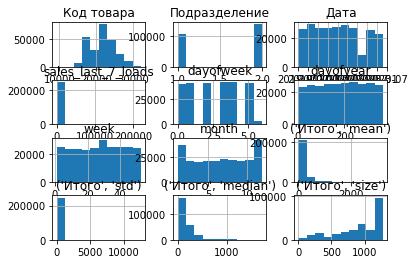

In [184]:
Xtrn.hist()

In [185]:
feats = ["Код товара", "Подразделение", "sales_last_7_loads", "dayofweek", "dayofyear", "week", "month", ("Итого", "mean"), ("Итого", "std"), ("Итого", "median"), ("Итого", "size")]

X_train = Xtrn[feats].values
X_test = Xtest[feats].values

y_train = Ytrn["Итого"].values
y_train_log = np.log(Ytrn["Итого"].values)

c:\Users\derachic_ai\anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [187]:
model = DecisionTreeRegressor(max_depth=10)
scores = cross_val_score(model, X_train, y_train_log, cv=3, scoring="neg_mean_absolute_error")

np.mean(scores), np.std(scores)

(-0.25894369547593094, 0.0010195821631032692)

In [188]:
scores

array([-0.25862912, -0.25788234, -0.26031963])

In [255]:
model.fit(X_train, y_train_log)
y_pred = model.predict(X_test)
eli5.show_weights(model, feature_names=["Код товара", "Подразделение", "sales_last_7_loads", "dayofweek", "dayofyear", "week", "month", "mean", "std", "median", "size"])

c:\Users\derachic_ai\anaconda3\lib\site-packages\eli5\sklearn\treeinspect.py:64: RuntimeWarning: invalid value encountered in true_divide
  value_ratio=list(value / value.sum()),


Weight,Feature
0.9478,sales_last_7_loads
0.0381,dayofweek
0.0032,size
0.0023,Подразделение
0.0020,dayofyear
0.0016,median
0.0015,Код товара
0.0010,std
0.0010,mean
0.0007,month


In [258]:
y_pred_exp =  pd.DataFrame(np.exp(y_pred))
diff = pd.DataFrame({'A': y_pred_exp[0],
             'B': np.array(Ytest["Итого"]),
             'C': np.absolute(y_pred_exp[0] - np.array(Ytest["Итого"]))
             })

diff["C"].sum()

5503498.585430152